
Variational Auto Encoders (VAEs)

En esta sesión usaremos diferentes tipos de VAEs. Como recordaréis, estos modelos asumen que existe una distribución latente de menos dimensiones que genera las variables observadas. El objetivo es estimar esta distribución usando una arquitecture de auto codificador, donde el codificador nos estima la distribución de las variables latentes y el decodificador es capaz de generar muestras a partir de estas variables.

Utilizaremos la librería `pythae` que implementa muchas variantes de estos modelos. Esta librería facilita bastante la construcción y el entrenamiento de los modelos.

In [ ]:
!pip install --quiet pythae

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset
import torch
from tqdm.auto import tqdm
import torchvision.datasets as datasets

from matplotlib import pyplot as plt

import numpy as np

from pythae.pipelines import GenerationPipeline
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.trainers.training_callbacks import TrainHistoryCallback, TrainingCallback, CallbackHandler
from pythae.data import BaseDataset

from time import time
from datetime import timedelta
init_time = time()

device = torch.device("cuda")

torch.__version__, torch.cuda.is_available(), device

('2.4.1+cu121', True, device(type='cuda'))

In [ ]:
!nvidia-smi

Wed Oct  9 19:28:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Primero redefinireremos un par de clases para el entrenamiento de los modelos para hacerlas algo menos verbosas que la clase que viene por defecto en la librería simplemente para hacer los resultados del notebook mas legibles.

In [ ]:
class BaseTrainerS(BaseTrainer):
    def _setup_callbacks(self):
        if self.callbacks is None:
            self.callbacks = [TrainingCallback()]

        self.callback_handler = CallbackHandler(
            callbacks=self.callbacks, model=self.model
        )

class ProgressBarEpochCallback(TrainingCallback):
    """
    A :class:`TrainingCallback` printing the training progress bar.
    """

    def __init__(self):
        self.train_progress_bar = None

    def on_train_begin(self, training_config: BaseTrainerConfig, **kwargs):
        rank = kwargs.pop("rank", -1)
        if rank == 0 or rank == -1:
            self.train_progress_bar = tqdm(
                total=training_config.num_epochs,
                unit="epoch"
            )

    def on_log(self, training_config: BaseTrainerConfig, logs, **kwargs):
        rank = kwargs.pop("rank", -1)

        if (rank == -1 or rank == 0):
            epoch_train_loss = logs.get("train_epoch_loss", None)
            epoch_eval_loss = logs.get("eval_epoch_loss", None)
            if epoch_eval_loss is None:
                self.train_progress_bar.set_description(f'Loss: {epoch_train_loss:3.4f} ')
            else:
                self.train_progress_bar.set_description(f'Loss: {epoch_train_loss:3.4f}/{epoch_eval_loss:3.4f} ')

    def on_epoch_end(self, training_config: BaseTrainerConfig, **kwargs):
        rank = kwargs.pop("rank", -1)
        if (rank == -1 or rank == 0):
            self.train_progress_bar.update(1)

Número de epochs que usarán los entrenamientos, podemos ajustarlo dependiendo del tiempo que tarden

In [ ]:
n_epochs = 500

## VAE MNIST (MLP Encoder-Decoder)

Empezaremos por un VAE que usa MLPs en el encoder y el decoder. Cargaremos el conjunto de datos MNIST (handwritten digits), pero solo usaremos una parte de los datos para no hacer el entrenamiento de los modelos demasiado largo. Las imágenes tienen un tamaño de 28x28 y los píxeles están en el rango [0-255]

In [ ]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16404777.86it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 507415.01it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4543146.71it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5215036.62it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



Seleccionaremos los primeros 5000 ejemplos como conjunto de entrenamiento y los últimos 5000 para evaluación (selección puramente arbitraria, se puede reducir el tamaño de los datos para que tarde menos el entrenamiento, pero obviamente disminuirá la calidad de los resultados)

In [ ]:

dsize = 5000
train_dataset = mnist_trainset.data[:dsize].reshape(-1, 1, 28, 28) / 255.
train_labels =  mnist_trainset.targets[:dsize]
eval_dataset = mnist_trainset.data[-dsize:].reshape(-1, 1, 28, 28) / 255.
eval_labels =  mnist_trainset.targets[-dsize:]

digdata =  BaseDataset(train_dataset, train_labels)
digeval =  BaseDataset(eval_dataset, eval_labels)

train_dataset.shape

torch.Size([5000, 1, 28, 28])

En esta librería debemos crear primero un objeto que permite configurar algunos elementos del modelo, en este caso las dimensiones que tienen los ejemplos y el número de variables latentes que tendrá el VAE. Obviamente el valor elegido parece pequeño, podéis experimentar el efecto de aumentar el número de latentes.


In [ ]:
vae_MLP_config = VAEConfig(
    input_dim=(1, 28, 28),
     latent_dim=8
 )

Crearemos un VAE clásico que asume que las variables latentes corresponden a distribuciones gausianas (prior). En este caso si no le pasamos las redes para el encoder y el decoder usará un MLP con unas dimensiones por defecto.

In [ ]:
vae_MLP_model = VAE(
     model_config=vae_MLP_config
 )

Si miramos el modelo podemos ver que el decoder tiene dos capas, una transforma del conjunto de variables latentes a una capa de 512 y otra nos da la salida de 28x28 usando ReLUs como funcion de activación y una sigmoide como salida para darnos valores en el rango [0-1].

El decoder tiene una capa de 512 con una función de activación ReLU y dos salidas, una obtiene la media de las variables latentes gausianas y otra el logaritmo de las variancias. A partir de aquí el modelo podrá calcular la ELBO y la NLL.

In [ ]:
vae_MLP_model

VAE(
  (decoder): Decoder_AE_MLP(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=8, out_features=512, bias=True)
        (1): ReLU()
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=784, bias=True)
        (1): Sigmoid()
      )
    )
  )
  (encoder): Encoder_VAE_MLP(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=784, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (embedding): Linear(in_features=512, out_features=8, bias=True)
    (log_var): Linear(in_features=512, out_features=8, bias=True)
  )
)

Tenir en compte que les capes embedding i log_var corresponen a les capes que modelen la mitjana i la desviació estàndar de forma separada.

Entrenaremos el número de epochs que se ha definido en la variable `n_epochs` usando AdamW y reduciendo la learning rate si la función de pérdida se estanca. Fijaos que estamos usando un _scheduler_ diferente que en las sesiones anteriores.

In [ ]:
training_config = BaseTrainerConfig(
   output_dir='my_model',
    num_epochs=n_epochs,
    learning_rate=1e-3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    steps_saving=None,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.9}
)

Definimos el objeto para el entrenamiento

In [ ]:
mcp = TrainHistoryCallback()
trainer = BaseTrainerS(model=vae_MLP_model,
                      training_config=training_config,
                      train_dataset=digdata,
                      eval_dataset= digeval,
                      callbacks=[mcp, ProgressBarEpochCallback()])

Model passed sanity check !
Ready for training.

INFO:pythae.trainers.base_trainer.base_trainer:Model passed sanity check !
Ready for training.



y entrenamos el modelo

In [ ]:
trainer.train()

Created my_model folder since did not exist.

INFO:pythae.trainers.base_trainer.base_trainer:Created my_model folder since did not exist.

Created my_model/VAE_training_2024-10-09_19-29-34. 
Training config, checkpoints and final model will be saved here.

INFO:pythae.trainers.base_trainer.base_trainer:Created my_model/VAE_training_2024-10-09_19-29-34. 
Training config, checkpoints and final model will be saved here.



  0%|          | 0/500 [00:00<?, ?epoch/s]

Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd990f8e470>

INFO:pythae.trainers.base_trainer.base_trainer:Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd990f8e470>

Successfully launched training !

I

18.602468395233153


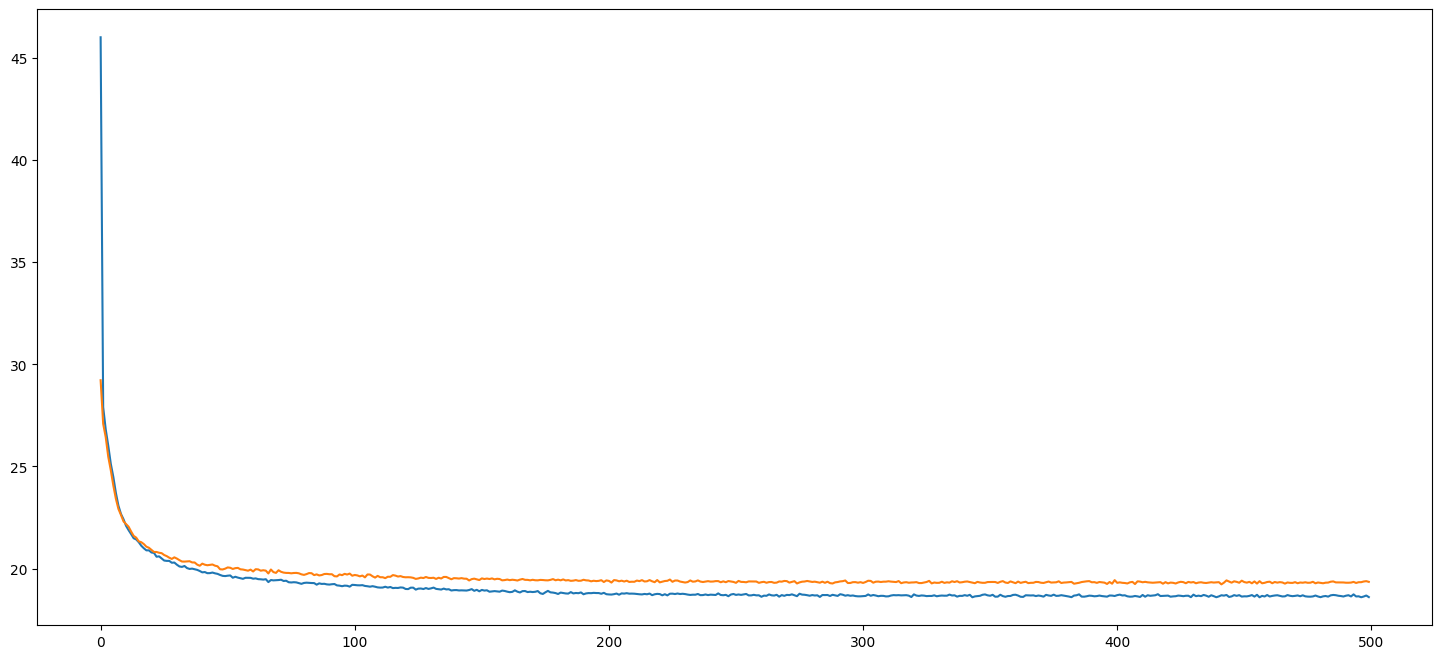

In [ ]:
plt.figure(figsize=(18,8))
print(mcp.history['train_loss'][-1])
plt.plot(mcp.history['train_loss']);
plt.plot(mcp.history['eval_loss']);


Podemos calcular la log verosimilitud del modelo para una muestra, esto permite comparar los modelos

In [ ]:
vae_MLP_model.get_nll(train_dataset.to(device))

-738.7178876511781

Ahora podemos generar muestras. En este caso obtendremos valores muestreando las distribuciones gausianas que corresponden a los parametros que ha aprendido el VAE y los pasaremos por el decodificador. Si los datos se han adaptado suficiente a la distribucion gaussiana que usamos como distribucion a priori deberiamos tener algo con sentido.

In [ ]:
gpipeline = GenerationPipeline(vae_MLP_model)

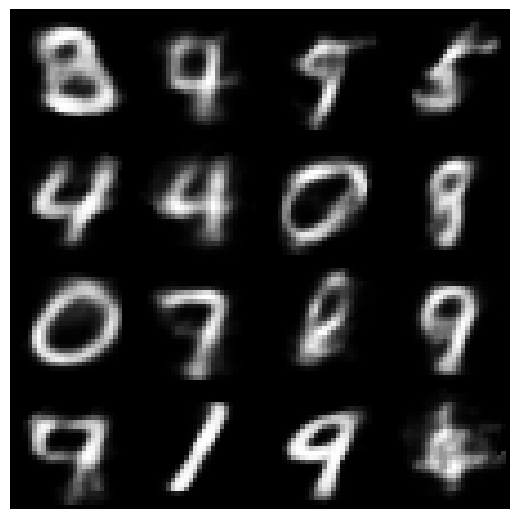

In [ ]:
nim = 4
samples = gpipeline(nim*nim)
fig = plt.figure(figsize=(5,5))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow((samples[i].cpu().detach().permute(1,2,0).numpy()), cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0.)

Podemos ver que los digitos son ligeramente borrosos. Este es un problema habitual en los VAE entrenados con la distribucion gausiana como distribucion a priori.

Tambien podemos comprobar si el VAE es capaz de reconstruir ejemplos (lo hemos entrenado tambien para eso) usando los datos de validacion.

In [ ]:
reconstructions = vae_MLP_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

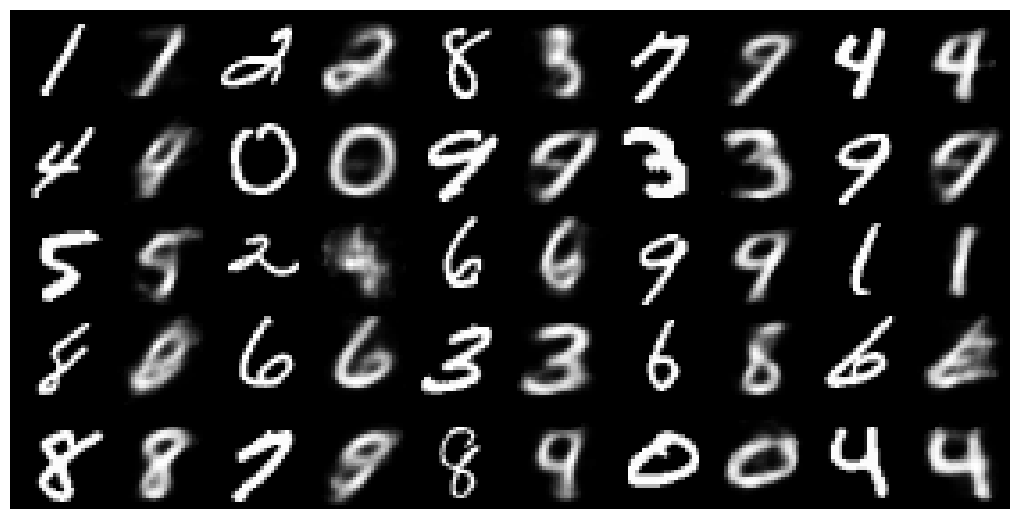

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(5):
        axes[i][2*j].imshow(eval_dataset[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][2*j].axis('off')
        axes[i][2*j+1].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][2*j+1].axis('off')

plt.tight_layout(pad=0.)

Los resultados no son fantasticos, pero en la mayoria de los casos la reconstruccion al menos se corresponde con el digito.

## VAE MNIST (ResNet Encoder-Decoder)

Vamos ahora a cambiar la arquitectura de la red para utilizar una red residual (ResNet) en lugar de un MLP. La libreria ya tiene una red predefinida para cada parte de la red. El encoder reduce las dimensiones de la entrada con las convoluciones (downscaling) hasta llegar a una capa que es transformada en la media y log variancia de las variables latentes y un decoder que transforma las variables latentes reescalando (upscaling) con convoluciones transpuestas en la imagen final

In [ ]:
from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST

In [ ]:
vae_Resnet_config = VAEConfig(
    input_dim=(1, 28, 28),
     latent_dim=8
 )

Definimos el modelo igual que antes, pero ahora le pasamos las nuevas redes para el encoder y el decoder.

In [ ]:
vae_Resnet_model = VAE(
     model_config=vae_Resnet_config,
    encoder=Encoder_ResNet_VAE_MNIST(vae_Resnet_config),
    decoder=Decoder_ResNet_AE_MNIST(vae_Resnet_config)
 )

Podéis ver los detalles de la arquitectura que se usa  descomentando las siguientes dos celdas

In [ ]:
Encoder_ResNet_VAE_MNIST(vae_Resnet_config)

Encoder_ResNet_VAE_MNIST(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): Sequential(
      (0): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
  )
  (embedding): Linear(in_features=2048, out_features=8, bias=True)
  (log_v

In [ ]:
#Decoder_ResNet_AE_MNIST(vae_Resnet_config)

Entrenamos de igual manera

In [ ]:
training_config = BaseTrainerConfig(
   output_dir='my_model',
    num_epochs=n_epochs,
    learning_rate=1e-3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    steps_saving=None,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.9}
 )

In [ ]:
mcp = TrainHistoryCallback()
trainer = BaseTrainerS(model=vae_Resnet_model,
                      training_config=training_config,
                      train_dataset=digdata,
                      eval_dataset=digeval,
                      callbacks=[mcp, ProgressBarEpochCallback()])

Model passed sanity check !
Ready for training.

INFO:pythae.trainers.base_trainer.base_trainer:Model passed sanity check !
Ready for training.



In [ ]:
trainer.train()

Created my_model/VAE_training_2024-10-09_19-34-23. 
Training config, checkpoints and final model will be saved here.

INFO:pythae.trainers.base_trainer.base_trainer:Created my_model/VAE_training_2024-10-09_19-34-23. 
Training config, checkpoints and final model will be saved here.



  0%|          | 0/500 [00:00<?, ?epoch/s]

Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd990fc6350>

INFO:pythae.trainers.base_trainer.base_trainer:Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd990fc6350>

Successfully launched training !

I

Obtenemos una relativa ganancia en la funcion de perdida

16.968280696868895


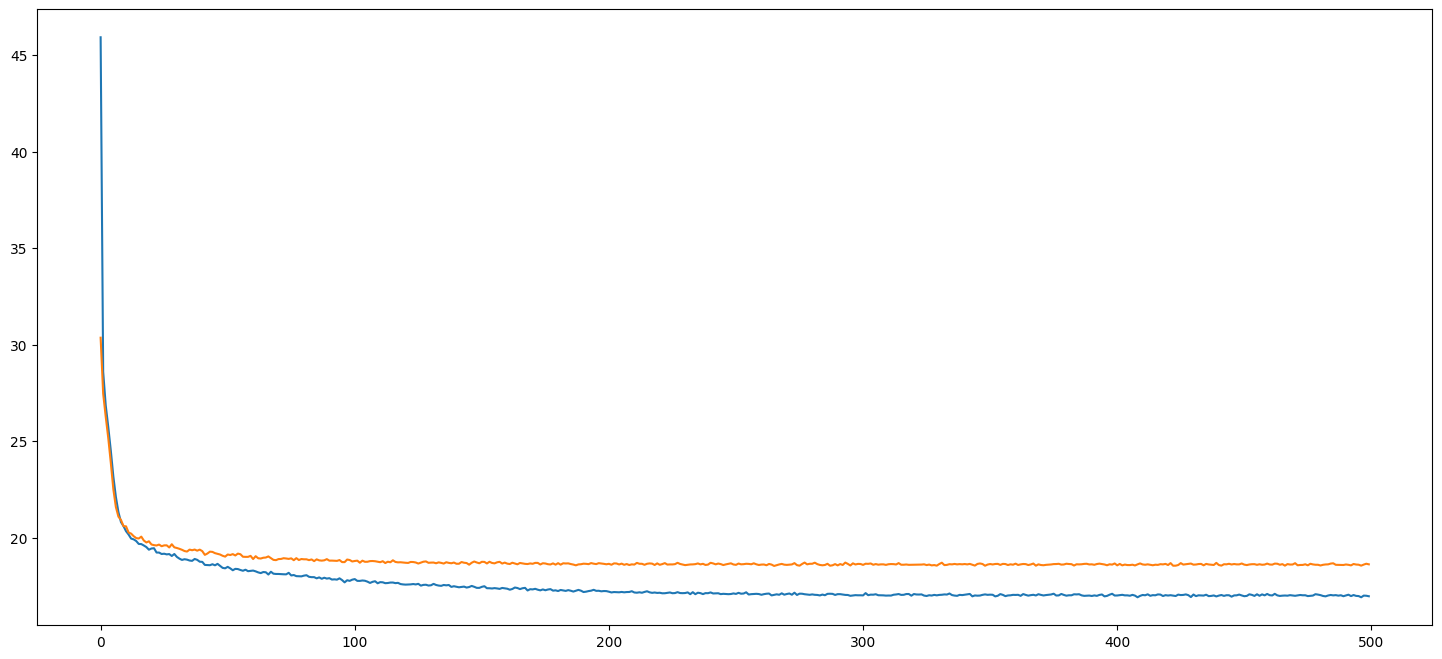

In [ ]:
plt.figure(figsize=(18,8))
print(mcp.history['train_loss'][-1])
plt.plot(mcp.history['train_loss']);
plt.plot(mcp.history['eval_loss']);


La NLL no es muy diferente que en el modelo anterior

In [ ]:
vae_Resnet_model.get_nll(train_dataset.to(device))

-736.89193082459

In [ ]:
gpipeline = GenerationPipeline(vae_Resnet_model)

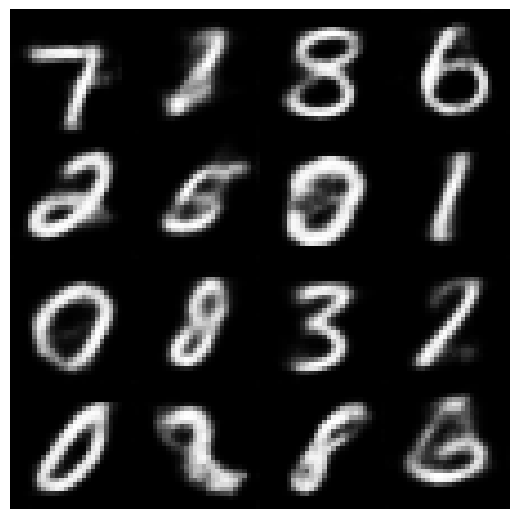

In [ ]:
nim = 4
samples = gpipeline(nim*nim)
fig = plt.figure(figsize=(5,5))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(samples[i].cpu().detach().permute(1,2,0).numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0.)

Las muestras son algo mejores, probablemente algo menos borrosas que las que obtenemos con el VAE anterior.

Podemos ver como lo hace al reconstruir el conjunto de validacion.

In [ ]:
reconstructions = vae_Resnet_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

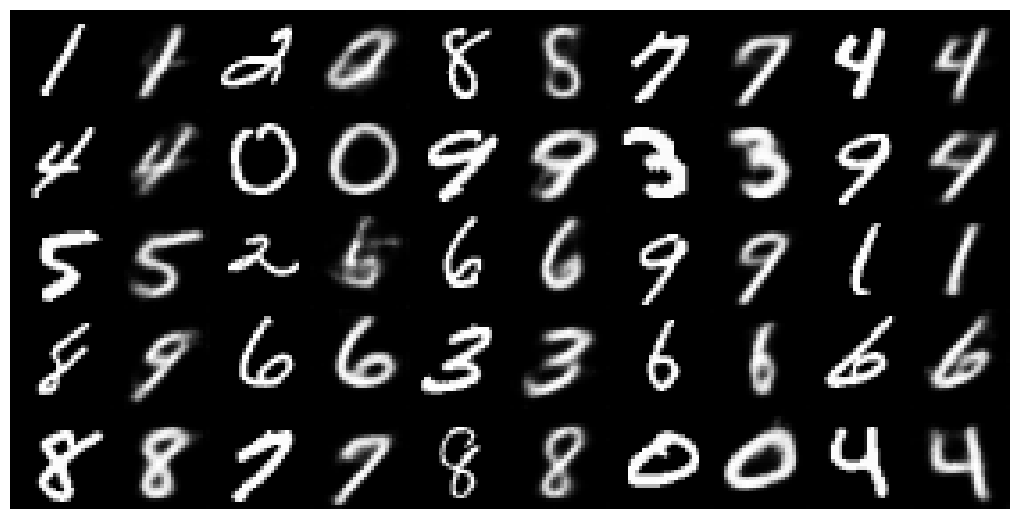

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(5):
        axes[i][2*j].imshow(eval_dataset[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][2*j].axis('off')
        axes[i][2*j+1].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][2*j+1].axis('off')

plt.tight_layout(pad=0.)

Los resultados parecen mejores que el primer VAE

Podemos aprovechar también esto para probar una cualidad que también tienen los VAEs que es la posibilidad de interpolar entre ejemplos. En este caso el espacio de interpolación es el espacio definido por las variables latentes, que es de menos dimensionalidad que en los flujos.

Vamos a interpolar entre dos muestras reales, para ello el método es codificar la muestra origen y destino y obtener un vector que conecta estas interpolaciones en el espacio latente. Hacemos un muestreo en la recta que los conecta a intervalos regulares. Estos puntos se pasan por el decodificador para obtener las muestras interpoladas. Podeis probar a cambiar los ejemplos        que se interpolan.

In [ ]:
ninter = 15
interpolations = vae_Resnet_model.interpolate(eval_dataset[0].to(device),
                                              eval_dataset[2].to(device).unsqueeze(0),
                                              granularity=ninter).squeeze(0).detach().cpu()

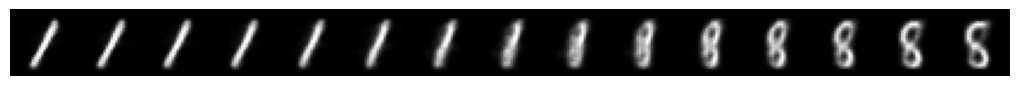

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=ninter, figsize=(10, 5))
axes

for i in range(ninter):
        axes[i].imshow(interpolations[i], cmap='gray')
        axes[i].axis('off')

plt.tight_layout(pad=0.)

Si el VAE ha aprendido una buena transformación la transicion debería ser relativamente suave.

## VQ VAE

El Vector Quantized VAE (no es realmente un VAE) hace una discretizacion del espacio asignando a la entrada un vector de un conjunto limitado de vectores que es ajustado durante el entrenamiento para obtener la mejor reconstruccion.

In [ ]:
from pythae.models import VQVAE, VQVAEConfig

In [ ]:
vqvae_config = VQVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=8,
    commitment_loss_factor=0.25,
    quantization_loss_factor=1.0,
    num_embeddings=512,
    use_ema=True,
    decay=0.99
 )

In [ ]:
vqvae_model = VQVAE(
     model_config=vqvae_config,
 )

In [ ]:
training_config = BaseTrainerConfig(
   output_dir='my_model',
    num_epochs=n_epochs,
    learning_rate=1e-3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    steps_saving=None,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.9}
 )

In [ ]:
mcp = TrainHistoryCallback()
trainer = BaseTrainerS(model=vqvae_model,
                      training_config=training_config,
                      train_dataset=digdata,
                      eval_dataset=digeval,
                      callbacks=[mcp, ProgressBarEpochCallback()])

Model passed sanity check !
Ready for training.

INFO:pythae.trainers.base_trainer.base_trainer:Model passed sanity check !
Ready for training.



In [ ]:
trainer.train()

Created my_model/VQVAE_training_2024-10-09_19-39-26. 
Training config, checkpoints and final model will be saved here.

INFO:pythae.trainers.base_trainer.base_trainer:Created my_model/VQVAE_training_2024-10-09_19-39-26. 
Training config, checkpoints and final model will be saved here.



  0%|          | 0/500 [00:00<?, ?epoch/s]

Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd960992f80>

INFO:pythae.trainers.base_trainer.base_trainer:Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd960992f80>

Successfully launched training !

I

9.995860719680786


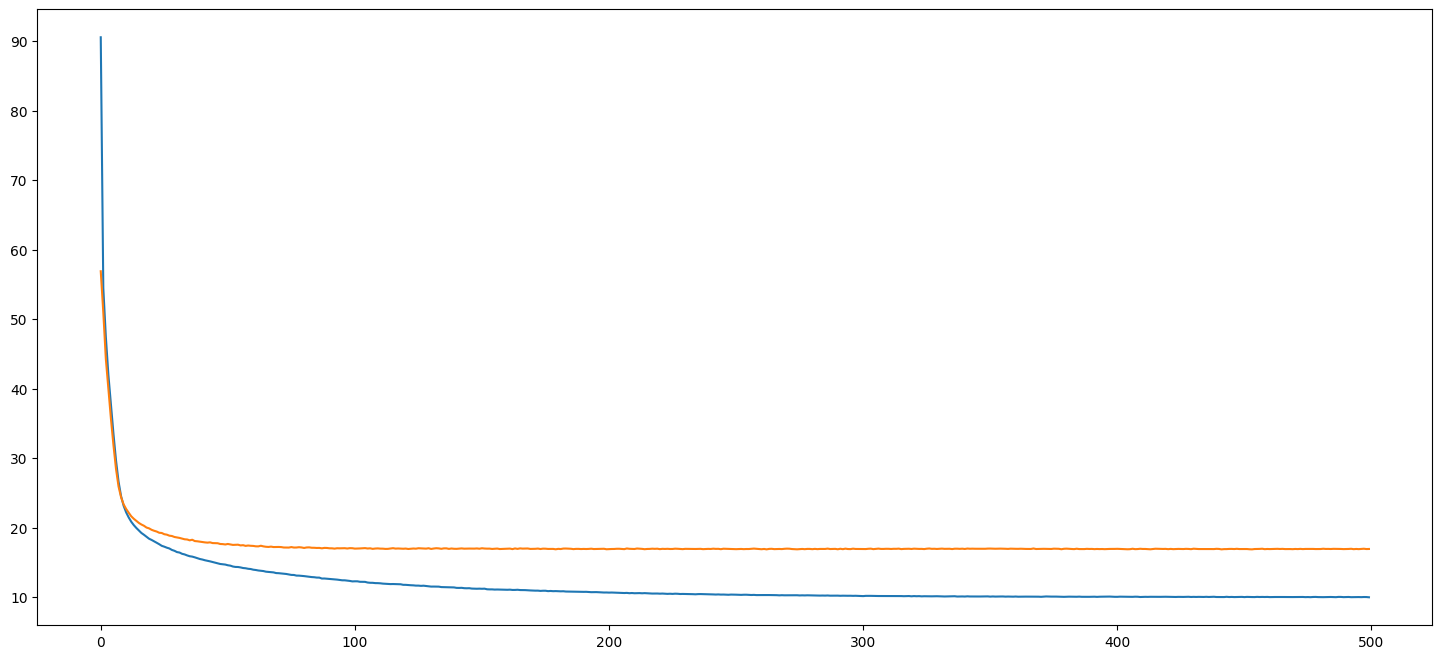

In [ ]:
plt.figure(figsize=(18,8))
print(mcp.history['train_loss'][-1])
plt.plot(mcp.history['train_loss']);
plt.plot(mcp.history['eval_loss']);


Podemos ver que la funcion de perdida es algo mejor.

En este caso no podemos calcular la NLL ya que realmente VQVAE no es un VAE

Si muestreamos

In [ ]:
gpipeline = GenerationPipeline(vqvae_model)

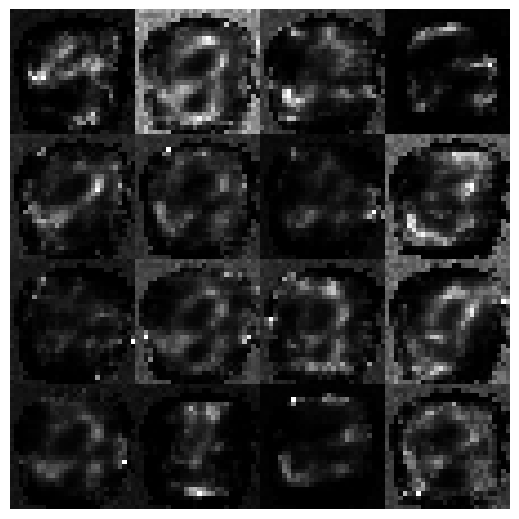

In [ ]:
nim = 4
samples = gpipeline(nim*nim)
fig = plt.figure(figsize=(5,5))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(samples[i].cpu().detach().permute(1,2,0).numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0.)

El muestreo es francamente terrible, esto es basicamente debido a que estamos usando una distribucion gausiana cuando el conjunto de vectores que cuantizan el espacio no sigue esta distribucion.

In [ ]:
reconstructions = vqvae_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

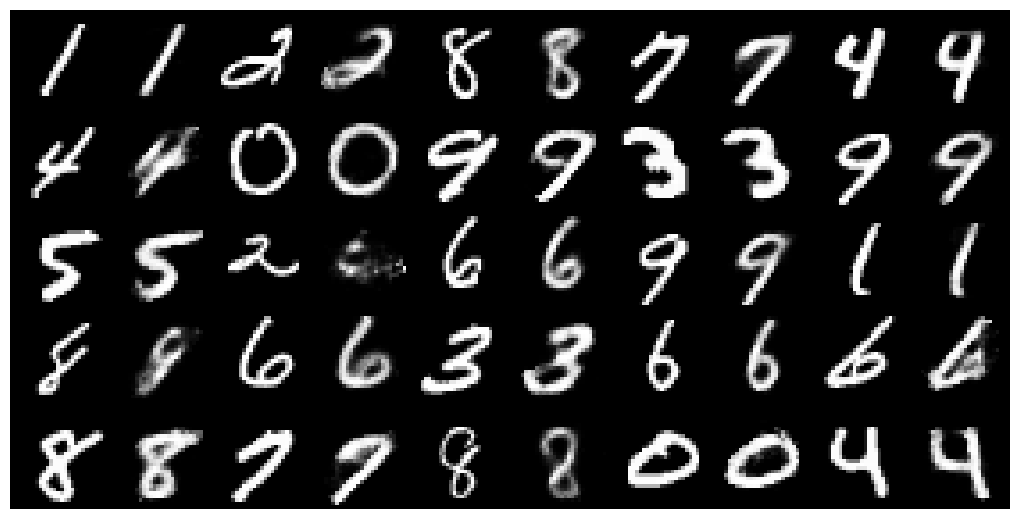

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(5):
        axes[i][2*j].imshow(eval_dataset[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][2*j].axis('off')
        axes[i][2*j+1].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][2*j+1].axis('off')

plt.tight_layout(pad=0.)

En cambio tenemos mejores reconstrucciones (salvo excepciones, que tambien son dificiles para los otros VAEs) y ya no son borrosas debido a la cuantización

## Muestreo con Gausian Mixture Models

Como comentamos en teoría, los VAEs pueden tener un problema de discordancia entre la distribución a priori y la distribución que genera el decodificador de manera que masas de probabilidad que deberían ser probables no lo son en la generación y masas de probabilidad que tienen poca probabilidad en los datos son generadas con mayor frecuencia.

Podemos corregirlo entrenando un modelo para hacer el muestreo que reajuste la distribucion basándonos en una distribución a priori más compleja.

Una forma de mejorar la capacidad de muestreo es entrenar un modelo que se ajuste mejor a la distribucion que sigue la cuantizacion, de manera que las muestras no vengan de una gausiana (la que usamos por defecto) sino de una distribucion mas compleja.

Por ejemplo podemos considerar que la distribucion que tenemos corresponde a una mezcla de gausianas y estimar sus parametros, de manera que las diferentes modas de las gausianas esten concentradas en las partes del espacio donde estan los ejemplos que es capaz de generar el decodificador. Ahora las muestras fuera de esas modas tendran menos probabilidad de ser generadas.

Se ha elegido `20` como tamaño de la mezcla de gausianas _magicamente_, pero podéis probar el efecto de usar más o menos componentes. El sampler ajustara un GMM a los latentes de los datos de entrenamiento y el muestreo se hará obteniendo muestras acorde con la distribución aprendida.



<font color="blue" size=4>
¿recordais como se ajusta un Gaussian Mixture model? Deberíais haberlo visto en alguna asignatura donde se expliquen métodos de clustering

 </font>

In [ ]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig, IAFSamplerConfig, IAFSampler, PixelCNNSampler, PixelCNNSamplerConfig

In [ ]:
# set up GMM sampler config
gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=20
)

# create gmm sampler
gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=vqvae_model
)

# fit the sampler
gmm_sampler.fit(train_dataset)

Si muestreamos la distribución

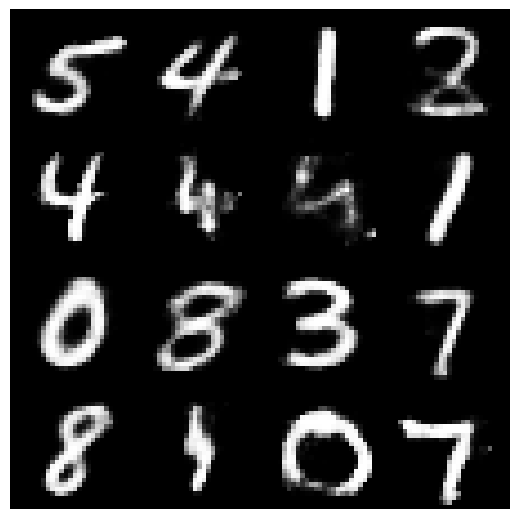

In [ ]:
nim = 4
samples =  gmm_sampler.sample(num_samples=nim*nim)
fig = plt.figure(figsize=(5,5))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(samples[i].cpu().detach().permute(1,2,0).numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0.)

Ahora si que obtenemos muestras de digitos minimamente reconocibles.

# VAE con flujo normalizante

El GMM no da suficiente libertad a la hora de ajustar una distribución a priori que permita un mejor muestreo. Una posibilidad es aprender un flujo normalizante que haga la transformación entre la distribución a priori gausiana y la que necesita el decodificador.

Vamos a probar usando un Flujo Auto Regresivo inverso. Este tiene la ventaja sobre el flujo auto regresivo de que es más rápido generando muestras ya que lo aprendemos al revés de lo habitual (de distribución a priori hacia los datos).

In [ ]:
training_config = BaseTrainerConfig(
   output_dir='my_model',
    num_epochs=100,
    learning_rate=1e-3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    steps_saving=None,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.9}
)

# set up IAF sampler config
IAF_sampler_config = IAFSamplerConfig(
    n_made_blocks =2,
    n_hidden_in_made = 3,
    hidden_size = 1024

)

# create gmm sampler
IAF_sampler = IAFSampler(
    sampler_config=IAF_sampler_config,
    model=vqvae_model
)

# fit the sampler
IAF_sampler.fit(train_dataset,eval_data=eval_dataset, training_config=training_config)

Model passed sanity check !
Ready for training.

INFO:pythae.trainers.base_trainer.base_trainer:Model passed sanity check !
Ready for training.

Created my_model/IAF_training_2024-10-09_19-41-34. 
Training config, checkpoints and final model will be saved here.

INFO:pythae.trainers.base_trainer.base_trainer:Created my_model/IAF_training_2024-10-09_19-41-34. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd96c288a90>

INFO:pythae.trainers.base_trainer.base_trainer:Training params:
 - max_epochs: 100
 - per_device_train_batch_size

Training of epoch 1/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 1/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 22554.5721
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 22554.5721
Eval loss: 12101.7516
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 12101.7516
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 2/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 10140.5204
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 10140.5204
Eval loss: 8670.1734
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 8670.1734
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 3/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 8273.7715
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 8273.7715
Eval loss: 7921.7588
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7921.7588
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 4/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7803.8908
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7803.8908
Eval loss: 7630.9328
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7630.9328
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 5/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7603.1565
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7603.1565
Eval loss: 7493.5383
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7493.5383
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 6/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7482.1307
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7482.1307
Eval loss: 7380.0561
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7380.0561
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 7/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7383.6348
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7383.6348
Eval loss: 7309.4568
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7309.4568
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 8/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7317.3299
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7317.3299
Eval loss: 7253.9892
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7253.9892
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 9/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7271.3324
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7271.3324
Eval loss: 7213.0435
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7213.0435
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 10/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7239.5804
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7239.5804
Eval loss: 7196.852
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7196.852
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 11/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7210.4925
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7210.4925
Eval loss: 7177.9549
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7177.9549
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 12/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7191.6736
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7191.6736
Eval loss: 7150.8156
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7150.8156
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 13/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7172.9059
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7172.9059
Eval loss: 7134.0027
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7134.0027
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 14/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7150.5049
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7150.5049
Eval loss: 7112.7289
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7112.7289
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 15/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7127.5622
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7127.5622
Eval loss: 7111.4194
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7111.4194
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 16/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7111.361
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7111.361
Eval loss: 7069.8066
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7069.8066
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 17/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7094.4833
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7094.4833
Eval loss: 7073.9236
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7073.9236
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 18/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7085.7261
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7085.7261
Eval loss: 7059.7184
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7059.7184
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 19/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7069.8566
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7069.8566
Eval loss: 7033.3671
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7033.3671
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 20/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7054.2729
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7054.2729
Eval loss: 7083.0333
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7083.0333
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 21/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7068.308
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7068.308
Eval loss: 7016.8186
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7016.8186
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 22/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7032.5035
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7032.5035
Eval loss: 7010.8465
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7010.8465
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 23/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7020.5925
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7020.5925
Eval loss: 7007.6719
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7007.6719
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 24/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 7005.9388
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 7005.9388
Eval loss: 6989.7796
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6989.7796
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 25/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6994.0884
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6994.0884
Eval loss: 6981.6456
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6981.6456
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 26/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 26/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6989.4493
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6989.4493
Eval loss: 7002.3463
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7002.3463
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 27/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 27/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6990.4918
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6990.4918
Eval loss: 6981.3961
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6981.3961
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 28/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 28/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6980.4531
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6980.4531
Eval loss: 6982.3346
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6982.3346
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 29/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 29/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6973.8482
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6973.8482
Eval loss: 6992.8174
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6992.8174
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 30/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 30/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6961.1445
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6961.1445
Eval loss: 6966.4857
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6966.4857
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 31/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 31/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6946.5138
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6946.5138
Eval loss: 6952.4652
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6952.4652
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 32/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 32/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6943.7294
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6943.7294
Eval loss: 6942.1652
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6942.1652
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 33/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 33/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6928.5272
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6928.5272
Eval loss: 6926.1885
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6926.1885
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 34/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 34/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6928.5229
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6928.5229
Eval loss: 6977.8887
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6977.8887
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 35/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 35/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6933.036
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6933.036
Eval loss: 6954.8328
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6954.8328
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 36/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 36/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6911.9498
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6911.9498
Eval loss: 6940.9748
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6940.9748
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 37/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 37/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6918.4522
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6918.4522
Eval loss: 6935.6936
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6935.6936
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 38/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 38/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6909.8826
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6909.8826
Eval loss: 6936.9469
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6936.9469
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 39/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 39/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6891.9028
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6891.9028
Eval loss: 6899.237
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6899.237
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 40/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 40/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6879.0281
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6879.0281
Eval loss: 6942.5949
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6942.5949
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 41/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 41/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6882.8927
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6882.8927
Eval loss: 6918.1114
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6918.1114
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 42/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 42/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6873.7875
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6873.7875
Eval loss: 6925.0399
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6925.0399
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 43/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 43/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6871.0216
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6871.0216
Eval loss: 6901.5971
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6901.5971
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 44/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 44/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6855.4774
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6855.4774
Eval loss: 6902.9466
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6902.9466
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 45/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 45/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6859.4138
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6859.4138
Eval loss: 6917.7997
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6917.7997
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 46/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 46/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6851.8566
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6851.8566
Eval loss: 6912.168
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6912.168
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 47/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 47/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6851.2197
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6851.2197
Eval loss: 6908.2951
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6908.2951
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 48/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 48/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6835.9062
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6835.9062
Eval loss: 6905.4182
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6905.4182
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 49/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 49/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6830.053
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6830.053
Eval loss: 6889.0676
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6889.0676
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 50/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 50/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6834.5591
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6834.5591
Eval loss: 6904.0635
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6904.0635
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 51/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 51/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6841.9234
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6841.9234
Eval loss: 6920.8791
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6920.8791
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 52/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 52/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6829.3927
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6829.3927
Eval loss: 6886.649
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6886.649
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 53/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 53/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6821.7854
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6821.7854
Eval loss: 6900.5799
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6900.5799
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 54/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 54/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6815.8283
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6815.8283
Eval loss: 6935.8496
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6935.8496
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 55/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 55/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6820.8532
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6820.8532
Eval loss: 6898.093
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6898.093
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 56/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 56/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6806.471
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6806.471
Eval loss: 6925.2248
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6925.2248
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 57/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 57/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6817.2609
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6817.2609
Eval loss: 6885.8726
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6885.8726
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 58/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 58/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6806.4634
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6806.4634
Eval loss: 6906.3282
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6906.3282
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 59/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 59/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6793.3623
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6793.3623
Eval loss: 6930.0396
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6930.0396
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 60/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 60/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6785.8976
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6785.8976
Eval loss: 6882.7007
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6882.7007
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 61/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 61/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6784.2093
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6784.2093
Eval loss: 6932.7814
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6932.7814
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 62/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 62/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6787.9627
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6787.9627
Eval loss: 6894.3052
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6894.3052
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 63/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 63/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6768.3715
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6768.3715
Eval loss: 6908.5436
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6908.5436
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 64/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 64/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6782.2104
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6782.2104
Eval loss: 6902.865
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6902.865
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 65/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 65/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6764.0591
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6764.0591
Eval loss: 6938.9445
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6938.9445
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 66/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 66/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6766.2675
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6766.2675
Eval loss: 6908.3583
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6908.3583
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 67/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 67/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6761.5704
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6761.5704
Eval loss: 6893.3314
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6893.3314
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 68/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 68/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6746.8492
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6746.8492
Eval loss: 6912.0582
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6912.0582
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 69/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 69/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6739.2038
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6739.2038
Eval loss: 6896.8885
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6896.8885
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 70/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 70/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6734.283
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6734.283
Eval loss: 6969.6203
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6969.6203
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 71/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 71/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6731.0243
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6731.0243
Eval loss: 6891.8593
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6891.8593
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 72/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 72/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6748.2895
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6748.2895
Eval loss: 6930.9696
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6930.9696
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 73/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 73/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6738.968
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6738.968
Eval loss: 6918.8013
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6918.8013
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 74/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 74/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6720.8952
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6720.8952
Eval loss: 6912.4525
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6912.4525
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 75/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 75/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6705.337
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6705.337
Eval loss: 6916.6305
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6916.6305
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 76/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 76/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6701.4089
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6701.4089
Eval loss: 6905.3599
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6905.3599
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 77/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 77/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6704.5385
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6704.5385
Eval loss: 6911.416
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6911.416
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 78/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 78/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6703.3983
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6703.3983
Eval loss: 6941.7012
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6941.7012
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 79/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 79/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6693.077
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6693.077
Eval loss: 6947.672
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6947.672
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 80/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 80/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6672.7728
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6672.7728
Eval loss: 6913.7803
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6913.7803
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 81/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 81/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6670.2403
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6670.2403
Eval loss: 6961.0793
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6961.0793
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 82/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 82/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6669.4883
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6669.4883
Eval loss: 6993.4042
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6993.4042
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 83/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 83/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6664.9648
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6664.9648
Eval loss: 6948.7069
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6948.7069
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 84/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 84/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6665.5438
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6665.5438
Eval loss: 6954.7163
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6954.7163
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 85/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 85/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6652.1433
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6652.1433
Eval loss: 6974.2624
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6974.2624
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 86/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 86/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6651.9915
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6651.9915
Eval loss: 7005.732
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7005.732
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 87/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 87/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6645.8756
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6645.8756
Eval loss: 7151.2568
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7151.2568
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 88/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 88/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6640.2367
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6640.2367
Eval loss: 6956.7684
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6956.7684
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 89/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 89/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6633.5699
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6633.5699
Eval loss: 7018.3641
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7018.3641
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 90/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 90/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6644.1231
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6644.1231
Eval loss: 7033.7518
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7033.7518
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 91/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 91/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6627.9151
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6627.9151
Eval loss: 6976.4843
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 6976.4843
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 92/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 92/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6623.41
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6623.41
Eval loss: 7023.0784
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7023.0784
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 93/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 93/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6608.7799
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6608.7799
Eval loss: 7050.7334
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7050.7334
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 94/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 94/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6613.836
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6613.836
Eval loss: 7221.1748
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7221.1748
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 95/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 95/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6621.0115
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6621.0115
Eval loss: 7041.0577
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7041.0577
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 96/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 96/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6598.6713
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6598.6713
Eval loss: 7197.9356
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7197.9356
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 97/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 97/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6606.0901
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6606.0901
Eval loss: 7181.9885
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7181.9885
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 98/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 98/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6593.2698
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6593.2698
Eval loss: 7106.8201
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7106.8201
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 99/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 99/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6584.0697
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6584.0697
Eval loss: 7188.3417
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7188.3417
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------


Training of epoch 100/100:   0%|          | 0/20 [00:00<?, ?batch/s]

Eval of epoch 100/100:   0%|          | 0/20 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Train loss: 6594.8897
INFO:pythae.trainers.base_trainer.base_trainer:Train loss: 6594.8897
Eval loss: 7139.2703
INFO:pythae.trainers.base_trainer.base_trainer:Eval loss: 7139.2703
--------------------------------------------------------------------------
INFO:pythae.trainers.base_trainer.base_trainer:--------------------------------------------------------------------------
Training ended!
INFO:pythae.trainers.base_trainer.base_trainer:Training ended!
Saved final model in my_model/IAF_training_2024-10-09_19-41-34/final_model
INFO:pythae.trainers.base_trainer.base_trainer:Saved final model in my_model/IAF_training_2024-10-09_19-41-34/final_model
/usr/local/lib/python3.10/dist-packages/pythae/models/normalizing_flows/base/base_nf_model.py:127: FutureWarning: You are using `torch.load` with `wei

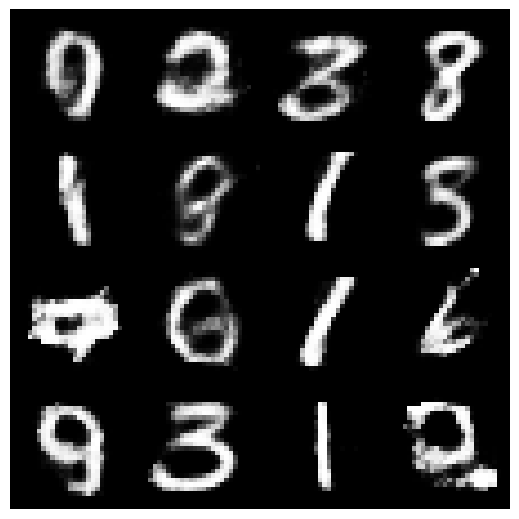

In [ ]:
nim = 4
samples =  IAF_sampler.sample(num_samples=nim*nim)
fig = plt.figure(figsize=(5,5))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow(samples[i].cpu().detach().permute(1,2,0).numpy(), cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0.)

# $\beta$-VAE

Con los VAE también puede intentar forzarse que las variables latentes correspondan a variables con algún significado en el dominio. El más sencillo de estos métodos es $\beta$-VAE que añade un peso en la función de pérdida del VAE de manera que tengamos un peso que cambie la influencia de la regularización. Dependiendo de como ajustemos ese peso podemos obtener un VAE donde las primeras variables controlan elementos de las muestras.

In [ ]:
from pythae.models import BetaVAEConfig
from pythae.models import BetaVAE

Podemos cambiar el parámetro $\beta$ del VAE para forzar un mayor "desenredo" de las variables latentes. En este VAE es difícil de controlar, pero podemos ver si obtenemos un VAE donde al explorar el rango de la primera variable latente y fijando el resto cambie algo con sentido en la muestra.

Dependiendo del valor del parametro podemos hacer que el VAE funcione peor, asi que necesita ajustarse con cuidado. (un rango entre 1 y 2 debería dar resultados coherentes)

Usando un valor de 1 tenemos obviamente el VAE original.

In [ ]:
bvae_Resnet_config = BetaVAEConfig(
    input_dim=(1, 28, 28),
     latent_dim=8,
     beta=1.5
 )

In [ ]:
bvae_Resnet_model = BetaVAE(
     model_config=bvae_Resnet_config,
    encoder=Encoder_ResNet_VAE_MNIST(bvae_Resnet_config),
    decoder=Decoder_ResNet_AE_MNIST(bvae_Resnet_config)
 )

In [ ]:
training_config = BaseTrainerConfig(
   output_dir='my_model',
    num_epochs=n_epochs,
    learning_rate=1e-3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    steps_saving=None,
    optimizer_cls="AdamW",
    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 5, "factor": 0.9}
)

Definimos el objeto para el entrenamiento

In [ ]:
mcp = TrainHistoryCallback()
trainer = BaseTrainerS(model=bvae_Resnet_model,
                      training_config=training_config,
                      train_dataset=digdata,
                      eval_dataset= digeval,
                      callbacks=[mcp, ProgressBarEpochCallback()])

Model passed sanity check !
Ready for training.

INFO:pythae.trainers.base_trainer.base_trainer:Model passed sanity check !
Ready for training.



y entrenamos el modelo

In [ ]:
trainer.train()

Created my_model/BetaVAE_training_2024-10-09_19-43-40. 
Training config, checkpoints and final model will be saved here.

INFO:pythae.trainers.base_trainer.base_trainer:Created my_model/BetaVAE_training_2024-10-09_19-43-40. 
Training config, checkpoints and final model will be saved here.



  0%|          | 0/500 [00:00<?, ?epoch/s]

Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd96cb36c20>

INFO:pythae.trainers.base_trainer.base_trainer:Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: None
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.91, 0.995)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7fd96cb36c20>

Successfully launched training !

I

20.245088386535645


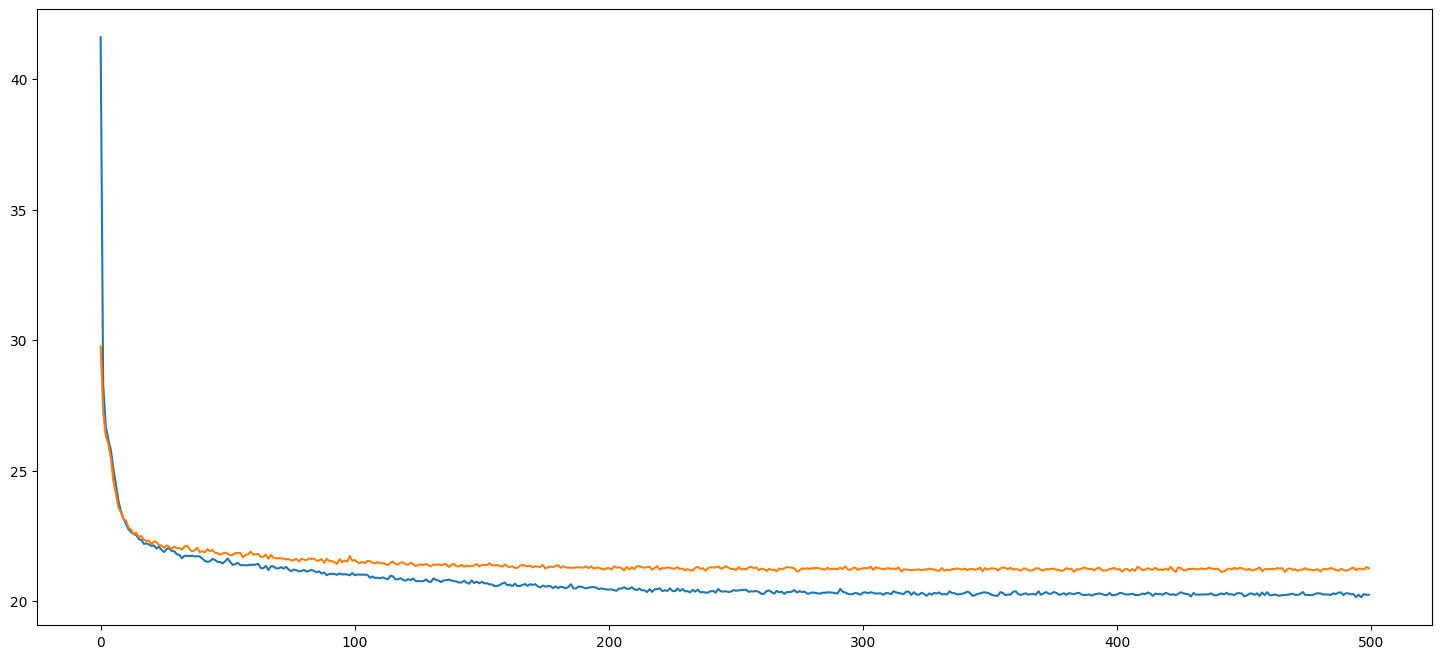

In [ ]:
plt.figure(figsize=(18,8))
print(mcp.history['train_loss'][-1])
plt.plot(mcp.history['train_loss']);
plt.plot(mcp.history['eval_loss']);


In [ ]:
bvae_Resnet_model.get_nll(train_dataset.to(device))

-737.3570358855463

Si no nos hemos pasado las muestras deberían ser minimamente decentes

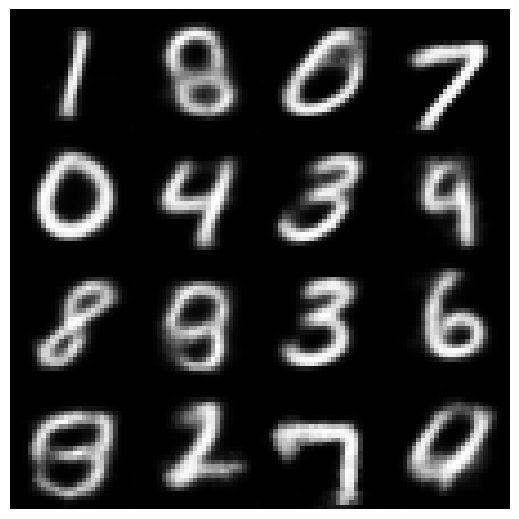

In [ ]:
gpipeline = GenerationPipeline(bvae_Resnet_model)
nim = 4
samples = gpipeline(nim*nim)
fig = plt.figure(figsize=(5,5))
for i in range(nim*nim):
    plt.subplot(nim, nim, i+1)
    plt.imshow((samples[i].cpu().detach().permute(1,2,0).numpy()), cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0.)

Necesitaremos el decodificador del VAE para poder experimentar con los latentes

In [ ]:
bvaed = bvae_Resnet_model.decoder

Generamos un vector gausiano y cambiamos el valor de la primera posición en un rango de valores a intervalos regulares con la esperanza de que controle por ejemplo el digito que se obtiene o su forma. Tambien es posible que no sear consistente lo que obtengamos, y reguiera una exploración de hiperparametros mas exhaustiva

Obviamente dependiendo del vector de ruido que se genere saldran diferentes cosas cada vez que ejecuteis la celda, podeis substituirlo por un vector de ceros para que sea reproducible o ejecutarlo varias veces para ver el efecto.

Tambien podeis cambiar la variable que se modifica.


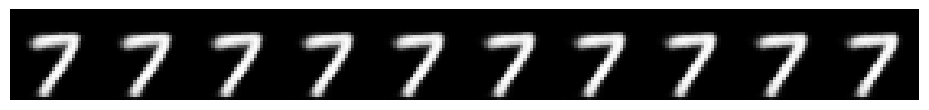

In [ ]:
noise = torch.randn((1,8))
# noise = torch.zeros((1,8))
fig = plt.figure(figsize=(10,15))
for i, v in enumerate(torch.arange(-2,2,0.4)):
    noise[0,0] = v
    samp = bvaed(noise.to(device))['reconstruction'].cpu().detach().squeeze()
    plt.subplot(1, 11, i+1)
    plt.imshow(samp, cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0.)

0;

In [ ]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:19:47.111424


Fer un restart del kernel després dels pip install.
Buscar el dataset a la documentació de torch per a veure com es fa el DataLoader. Utilitzar inclús la part que transforma les dades a tensors i que normalitza les dades. Aplicar el VAE al dataloader per a construir el dataset. Els classificadors poden ser qualsevol cosa. Per a trobar la distribució latent d'un batch, tenir en compte que el data loader retorna dues coses, els píxels i la etiqueta per separat. Tot i això, per a obtenir la representació latent s'ha d'utilitzar el mètode següent:

```
(...encoder...).latent_dist.mode()

vector.view(vector.size(0),-1)
```



In [ ]:
!pip install --quiet diffusers
!pip install --quiet omegaconf
!pip install --quiet transformers
!pip install --quiet accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.5 MB/s eta 0:00:00


## CIFAR EXAMPLE

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision
import itertools

### Cargar el modelo

In [ ]:
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionPipeline

model = "CompVis/stable-diffusion-v1-4"
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")
pipe = StableDiffusionPipeline.from_pretrained(model, vae=vae)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### DataLoader

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:03<00:00, 46360903.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
vae.to(device)

latents_train = []
etiquetas_train = []

for data, label in trainloader:

    with torch.no_grad():
        latents = vae.encode(data.to(device)).latent_dist.mode().detach().flatten().tolist()
        etiqueta = int(label.detach().squeeze().numpy())
        latents_train.append(latents)
        etiquetas_train.append(etiqueta)

In [ ]:
latents_test = []
etiquetas_test = []

for data, label in testloader:

    with torch.no_grad():
        latents = vae.encode(data.to(device)).latent_dist.mode().detach().flatten().tolist()
        etiqueta = int(label.detach().squeeze().numpy())
        latents_test.append(latents)
        etiquetas_test.append(etiqueta)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC

## Regresión logística

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(latents_train, etiquetas_train)


LogisticRegression(max_iter=1000)

In [ ]:
prediccions = clf.predict(latents_test)
accuracy_score(etiquetas_test, prediccions)

0.4378

In [ ]:
etiquetes_test_cm = [classes[i] for i in etiquetas_test]
prediccions_cm = [classes[i] for i in prediccions]

In [ ]:
cm = confusion_matrix(etiquetes_test_cm, prediccions_cm, labels = classes)

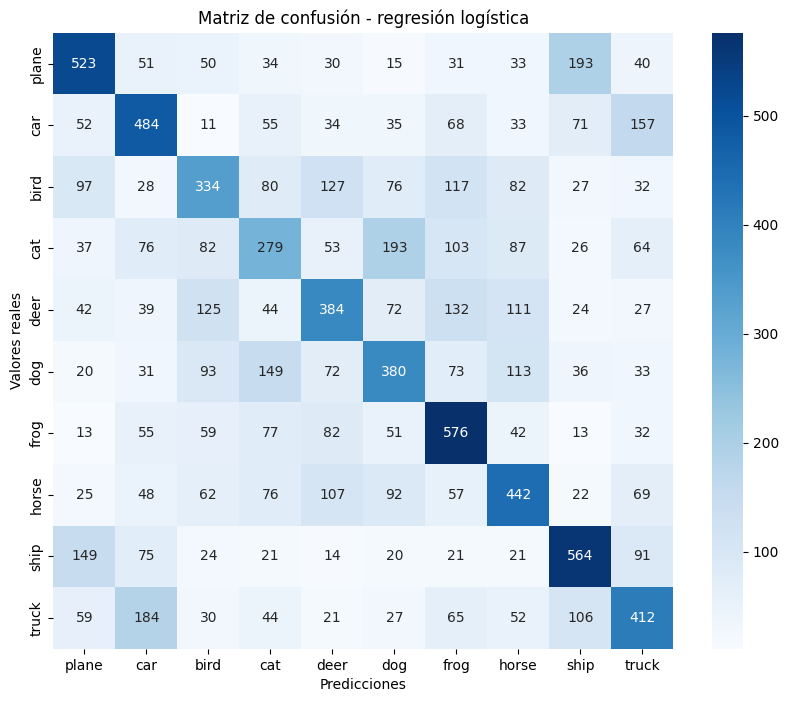

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión - regresión logística')
plt.show()

## SVC

In [ ]:
svc = SVC()
svc.fit(latents_train, etiquetas_train)

SVC()

In [ ]:
prediccions = svc.predict(latents_test)
accuracy_score(etiquetas_test, prediccions)

0.6225

In [ ]:
etiquetes_test_cm = [classes[i] for i in etiquetas_test]
prediccions_cm = [classes[i] for i in prediccions]

In [ ]:
cm = confusion_matrix(etiquetes_test_cm, prediccions_cm, labels = classes)

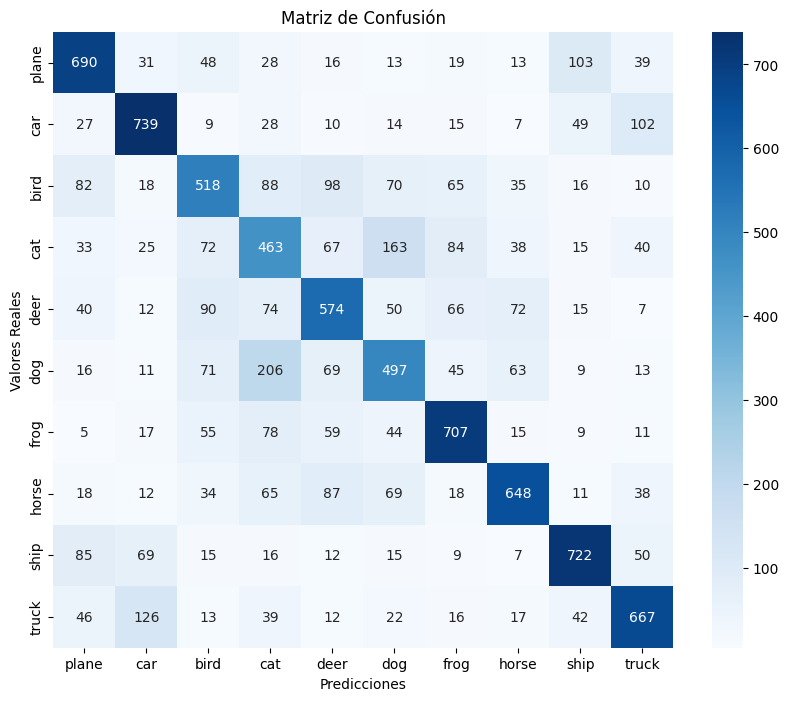

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión - SVC')
plt.show()